In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [100, 8]})

1. Organizing the project with pipelines

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from ML_utils import performance_evaluation_report

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

Load the data, separate the target and create the stratified train-test split:

In [5]:
df = pd.read_csv("../Handout16/credit_card_default.csv", na_values="")

X = df.copy()
y = X.pop("default_payment_next_month")

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

Prepare lists of numerical/categorical features:

In [6]:
num_features = X_train.select_dtypes(include="number") \
                      .columns \
                      .to_list()
cat_features = X_train.select_dtypes(include="object") \
                      .columns \
                      .to_list()

Sanity check that all columns are included in the lists

In [7]:
len(X_train.columns) == (len(num_features) + len(cat_features))

True

Define the OutlierRemover class:
<br>
<br>
We will remove values above/below +/- 3 st.d. from the average.

In [8]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError("""There are missing values in the array! 
                                Please remove them.""")

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = pd.Series(mean_vec + self.n_std * std_vec)
        self.upper_band_ = self.upper_band_.to_frame().transpose()
        self.lower_band_ = pd.Series(mean_vec - self.n_std * std_vec)
        self.lower_band_ = self.lower_band_.to_frame().transpose()
        self.n_features_ = len(self.upper_band_.columns)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = pd.concat(
            [self.upper_band_] * len(X_copy), 
            ignore_index=True
        )
        lower_band = pd.concat(
            [self.lower_band_] * len(X_copy), 
            ignore_index=True
        )
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

Define the numerical pipeline:

In [9]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

Define the numerical pipeline with OutlierRemover:

In [10]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("outliers", OutlierRemover())
])

Define the categorical pipeline:

In [11]:
cat_list = [
    list(X_train[col].dropna().unique()) for col in cat_features
]

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(categories=cat_list, 
                             sparse=False, 
                             handle_unknown="error", 
                             drop="first"))
])

Define the ColumnTransformer object:

In [12]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("numerical", num_pipeline, num_features),
#         ("categorical", cat_pipeline, cat_features)
#     ], 
#     remainder="drop"
# )

Define the full pipeline including the decision tree model:

In [13]:
# dec_tree = DecisionTreeClassifier(random_state=42)

# tree_pipeline = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("classifier", dec_tree)
# ])

Fit the pipeline to the data:

In [14]:
# tree_pipeline.fit(X_train, y_train)

Evaluate the performance of the entire pipeline:

In [15]:
# LABELS = ["No Default", "Default"]
# tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
#                                           y_test, labels=LABELS, 
#                                           show_plot=True)

# sns.despine()
# plt.tight_layout()

In [16]:
# tree_perf

Execute the rest of the pipeline to compare the results:

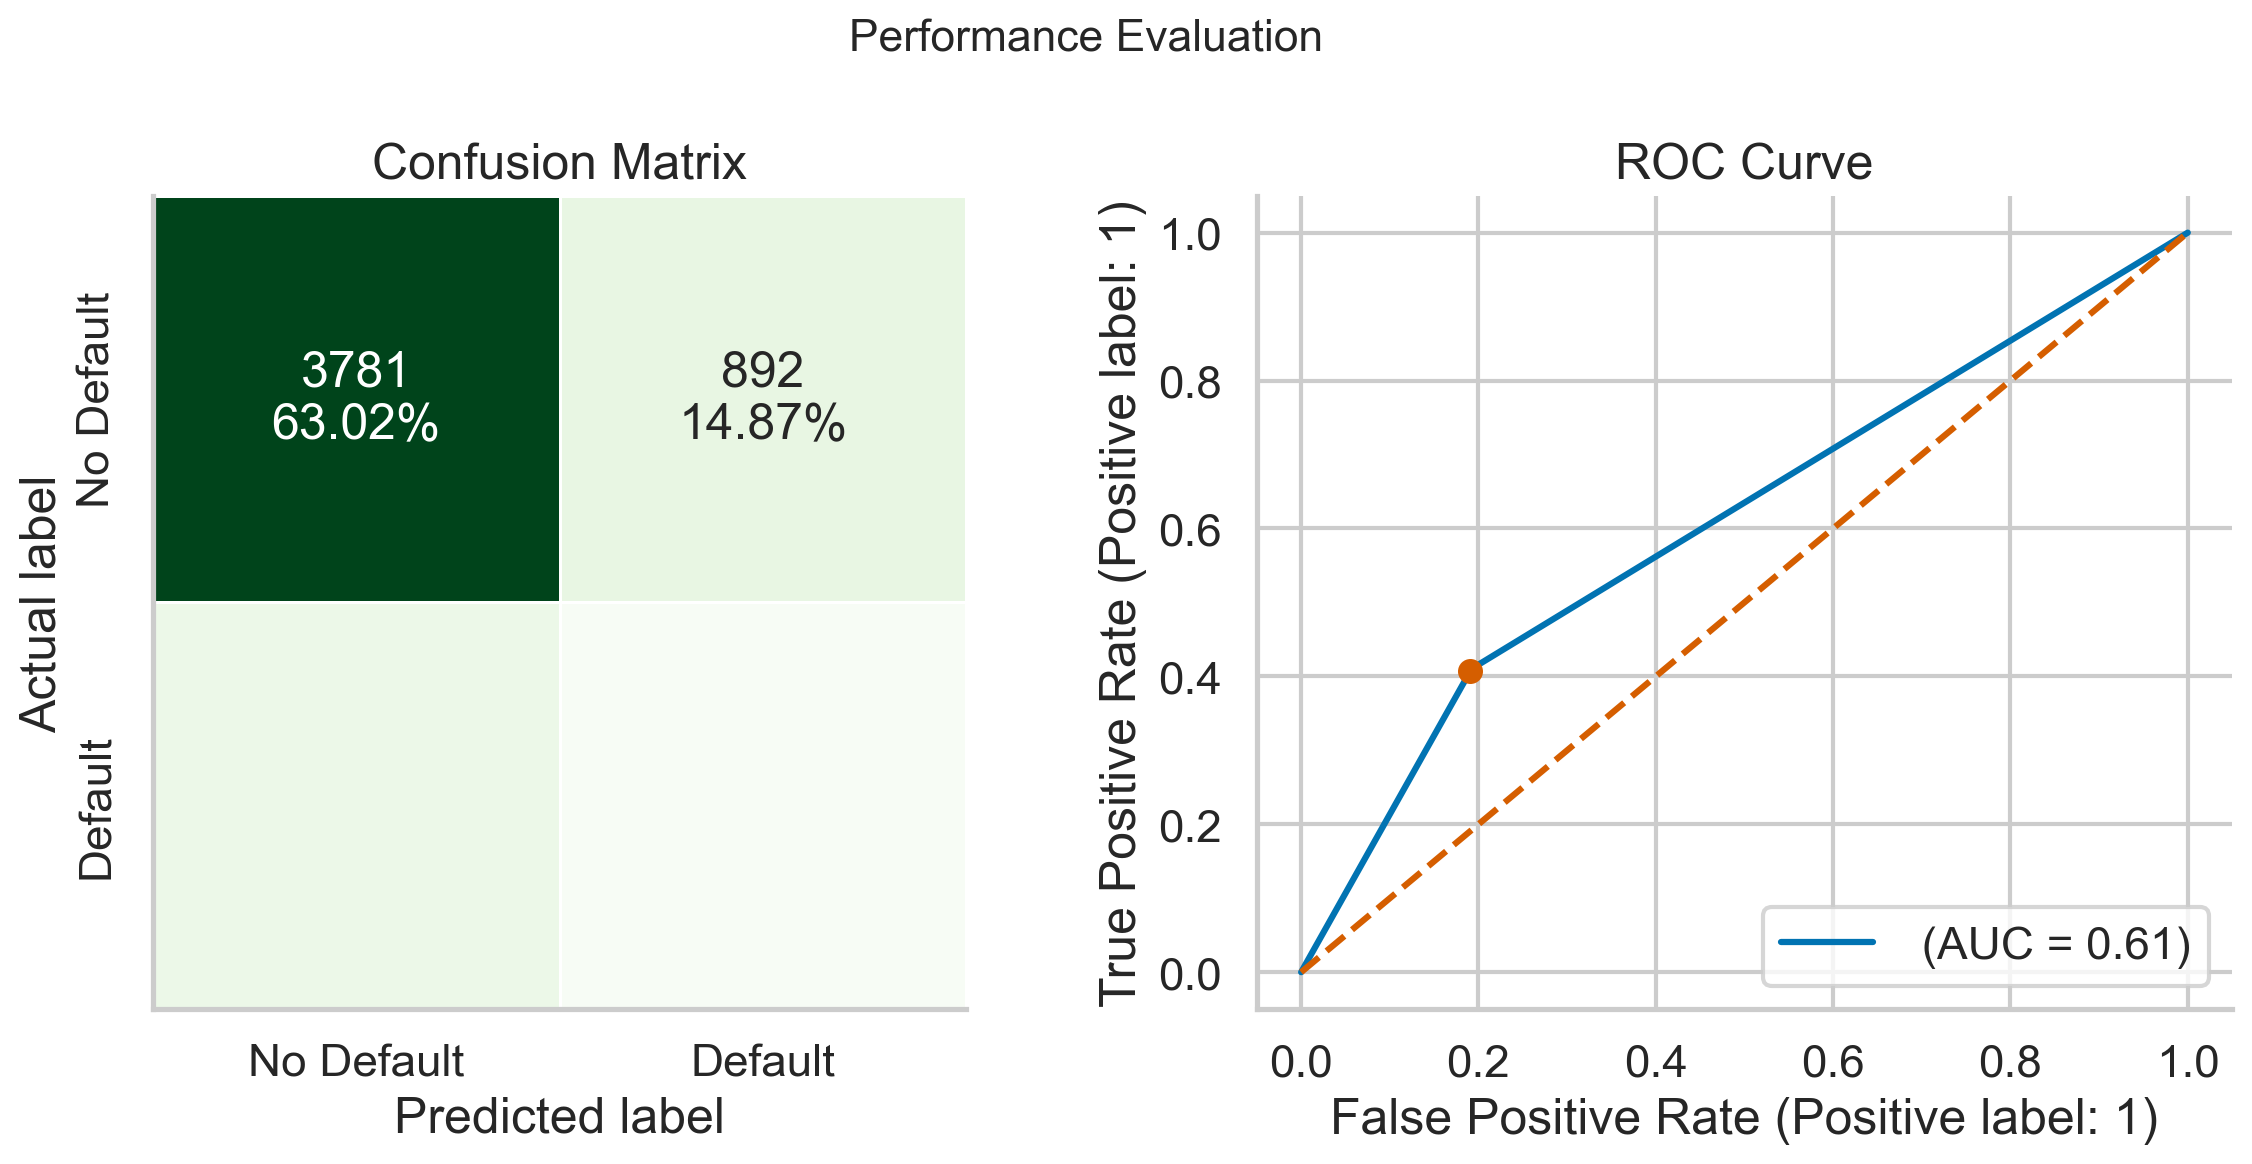

In [17]:
preprocessor = ColumnTransformer(transformers=[
    ("numerical", num_pipeline, num_features),
    ("categorical", cat_pipeline, cat_features)],
    remainder="drop")

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("classifier", dec_tree)])

tree_pipeline.fit(X_train, y_train)

LABELS = ["No Default", "Default"]
tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

sns.despine()
plt.tight_layout()

In [18]:
tree_perf

{'accuracy': 0.7203333333333334,
 'precision': 0.377529658060014,
 'recall': 0.4076865109269028,
 'specificity': 0.8091161994436122,
 'f1_score': 0.39202898550724635,
 'cohens_kappa': 0.21077497538963086,
 'matthews_corr_coeff': 0.2110374148258694,
 'roc_auc': 0.608982787005664,
 'pr_auc': 0.4582134167657523,
 'average_precision': 0.2850810668089482}

<br>
<br>

2. Accessing the elements of the pipeline

2.1. Display the structure of the pipeline:

In [19]:
tree_pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('numerical',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('outliers',
                                                   OutlierRemover())]),
                                  ['limit_bal', 'age', 'bill_statement_sep',
                                   'bill_statement_aug', 'bill_statement_jul',
                                   'bill_statement_jun', 'bill_statement_may',
                                   'bill_statement_apr', 'previous_payment_sep',
                                   'previous_payment_aug',
                                   'previous_payment_jul...
                                                                              'months',
                                                                              'Payment '
                                          

2.2 Access the estimator at the end of the pipeline:

In [20]:
tree_pipeline.named_steps["classifier"]

DecisionTreeClassifier(random_state=42)

2.3. Access the upper thresholds of the fitted OutlierRemover transformer:

In [21]:
(
    tree_pipeline
    .named_steps["preprocessor"]
    .named_transformers_["numerical"]["outliers"]
    .upper_band_
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,555890.511578,62.945993,271626.004006,261528.147261,252069.405868,235292.85113,222044.17518,216598.486524,54067.496948,66637.658658,57755.3464,49971.471286,49914.412427,58779.830767


In [22]:
( 
    tree_pipeline
    .named_steps["preprocessor"]
    .transformers_[0][1]["outliers"]
    .upper_band_
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,555890.511578,62.945993,271626.004006,261528.147261,252069.405868,235292.85113,222044.17518,216598.486524,54067.496948,66637.658658,57755.3464,49971.471286,49914.412427,58779.830767


<br>
<br>

3. Tuning hyperparameters using grid search and cross-validation

From above, we have a 44 levels of decision-tree model.
<br>
<br>
The maximum depth is the hyperparameter of the model.
<br>
Without limitation of maximum depth, we could overfit our model with training dataset, and not perform well in testing dataset. 
<br>
So there is a tradeoff between underfitting and overfitting.  
<br>
<br>
We can tune the maximum depth to achieve better performance.
<br>
We will also use cross-validation to do so.

In [ ]:
from sklearn.model_selection import (
    GridSearchCV, cross_val_score, 
    RandomizedSearchCV, cross_validate, 
    StratifiedKFold
)
from sklearn import metrics

Define the cross-validation scheme:
<br>
Here we use 5-fold.

In [ ]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

Evaluate the pipeline using cross-validation:

In [ ]:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

Add extra metrics to cross-validation:

In [ ]:
cv_scores = cross_validate(tree_pipeline, X_train, y_train, cv=k_fold, 
                           scoring=["accuracy", "precision", "recall", 
                                    "roc_auc"])
pd.DataFrame(cv_scores)

Define the parameter grid:

In [ ]:
param_grid = {
    "classifier__criterion": ["entropy", "gini"],
    "classifier__max_depth": range(3, 11),
    "classifier__min_samples_leaf": range(2, 11), 
    "preprocessor__numerical__outliers__n_std": [3, 4]
}

3.1 Run the exhaustive grid search:

In [ ]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid, 
                             scoring="recall", cv=k_fold, 
                             n_jobs=-1, verbose=1)

classifier_gs.fit(X_train, y_train)

In [ ]:
print(f"Best parameters: {classifier_gs.best_params_}") 
print(f"Recall (Training set): {classifier_gs.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}")

Evaluate the performance of the tuned pipeline:

In [ ]:
LABELS = ["No Default", "Default"]
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

sns.despine()
plt.tight_layout()

In [ ]:
tree_gs_perf

3.2 Run the randomized grid search:

In [ ]:
classifier_rs = RandomizedSearchCV(tree_pipeline, param_grid, 
                                   scoring="recall", cv=k_fold, 
                                   n_jobs=-1, verbose=1, 
                                   n_iter=100, random_state=42)
classifier_rs.fit(X_train, y_train)

In [ ]:
print(f"Best parameters: {classifier_rs.best_params_}") 
print(f"Recall (Training set): {classifier_rs.best_score_:.4f}") 
print(f"Recall (Test set): {metrics.recall_score(y_test, classifier_rs.predict(X_test)):.4f}")

Evaluate the performance of the Randomized Grid Search:

In [ ]:
tree_rs_perf = performance_evaluation_report(classifier_rs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

sns.despine()
plt.tight_layout()

In [ ]:
tree_rs_perf